In [1]:
import numpy as np
import casadi as cs
import os
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

from quad import Quadrotor3D
from utils import skew_symmetric, quaternion_to_euler, unit_quat, v_dot_q
from quad_opt import quad_optimizer

import pickle

In [2]:
def plot_intermediate(x_opt_acados, w_opt_acados):
    fig = plt.figure()
    plt.subplot(121)
    plt.plot(x_opt_acados[:,0],'r')
    plt.plot(x_opt_acados[:,1],'g')
    plt.plot(x_opt_acados[:,2],'b')

    #plt.plot(np.concatenate((yref[:quad_opt.n_nodes,0], [yref_N[0]])),'r--')
    #plt.plot(np.concatenate((yref[:quad_opt.n_nodes,1], [yref_N[1]])),'g--')
    #plt.plot(np.concatenate((yref[:quad_opt.n_nodes,2], [yref_N[2]])), 'b--')
    plt.title('Position xyz')
    
    plt.subplot(122)
    plt.plot(w_opt_acados[:,0],'r')
    plt.plot(w_opt_acados[:,1],'g')
    plt.plot(w_opt_acados[:,2],'b--')
    plt.plot(w_opt_acados[:,3],'c-.')
    plt.title('Control u')

rm -f libacados_ocp_solver_quad_OCP.so
rm -f acados_solver_quad_OCP.o
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o acados_solver_quad_OCP.o acados_solver_quad_OCP.c
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o quad_OCP_model/quad_OCP_expl_ode_fun.o quad_OCP_model/quad_OCP_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o quad_OCP_model/quad_OCP_expl_vde_forw.o quad_OCP_model/qua

Text(0.5, 1.0, 'Quaternion q')

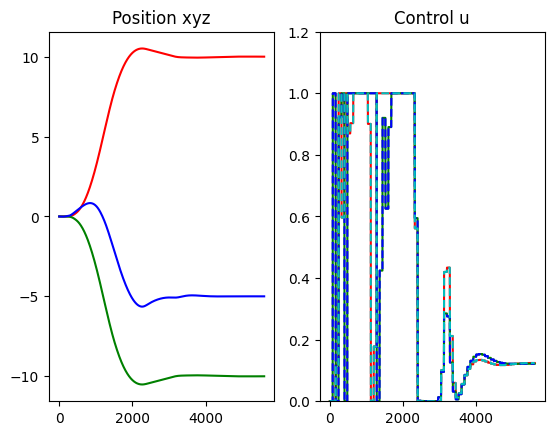

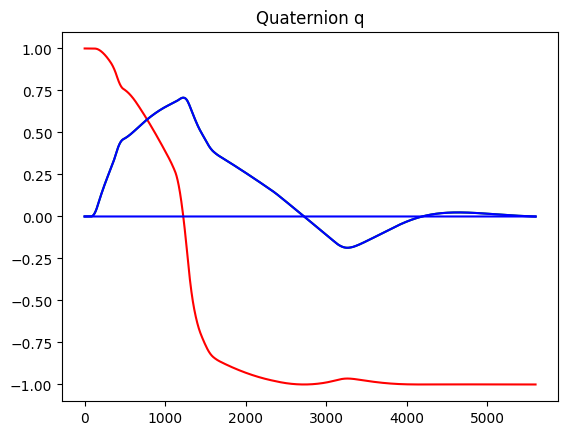

In [3]:
Nsim = 70# number of simulation steps
simulation_dt = 5e-4

# initial condition

quad = Quadrotor3D() # Controlled plant 
quad_opt = quad_optimizer(quad, t_horizon=1, n_nodes=25) # computing optimal control over model of plant

'''
x_trajectory = quad_opt.square_trajectory(quad_opt.n_nodes, quad_opt.optimization_dt) # arbitrary trajectory
u_trajectory = np.ones((x_trajectory.shape[0], 4))*0.16 # 0.16 is hover thrust 

# set the created trajectory to the ocp solver
yref, yref_N = quad_opt.set_reference_trajectory(x_trajectory, u_trajectory)
'''





x = np.array([0,0,0] + [1,0,0,0] + [0,0,0] + [0,0,0])

x_optim = np.empty((Nsim+1, x.shape[0])) * np.NaN
u_optim = np.empty((Nsim, 4)) * np.NaN


x_sim = x.reshape((1, x.shape[0]))
u_sim = np.empty((1,4))*np.NaN

x_target = np.array([10,-10,-5] + [1,0,0,0] + [0,0,0] + [0,0,0])
#print(x_target)
yref, yref_N = quad_opt.set_reference_state(x_target)

# Set quad to start position
quad.set_state(x)


# IDEA : create a 3D array of Nsim, stateidx, n_node ## How to visualize?
for i in range(Nsim):
    
    # I dont think I need to run optimization more times as with the case of new opt
    x_opt_acados, w_opt_acados = quad_opt.run_optimization(x)
    #x_opt_acados, w_opt_acados = quad_opt.run_optimization(x)
    #x_opt_acados, w_opt_acados = quad_opt.run_optimization(x)
    #print(u_sim)
    
    
    u = w_opt_acados[0,:] # control to be applied to quad
    u_optim[i,:] = u
    x_optim[i,:] = x
    #plot_intermediate(x_opt_acados, w_opt_acados)

    
    control_time = 0
    while control_time < quad_opt.optimization_dt: 
        # control the quad with the most recent u for the whole control period (multiple simulation steps for one optimization)
        quad.update(u, simulation_dt)
        x = np.array(quad.get_state(quaternion=True, stacked=True)) # state at the next optim step
        #print('j = ' + str(j) + '  ' + str(x[0:3]))

        u_sim = np.append(u_sim,u.reshape((1,u.shape[0])),axis=0)
        x_sim = np.append(x_sim,x.reshape((1,x.shape[0])),axis=0)

        control_time += simulation_dt
        

    
    
file = open('mpc_log.p', 'wb')
pickle.dump([x_sim, u_sim, quad], file)
file.close()



fig = plt.figure()
plt.subplot(121)
plt.plot(x_sim[:,0],'r')
plt.plot(x_sim[:,1],'g')
plt.plot(x_sim[:,2],'b')


#plt.plot(np.concatenate((yref[:quad_opt.n_nodes,0], [yref_N[0]])),'r--')
#plt.plot(np.concatenate((yref[:quad_opt.n_nodes,1], [yref_N[1]])),'g--')
#plt.plot(np.concatenate((yref[:quad_opt.n_nodes,2], [yref_N[2]])),'b--')
plt.title('Position xyz')


plt.subplot(122)
plt.plot(u_sim[:,0],'r')
plt.plot(u_sim[:,1],'g')
plt.plot(u_sim[:,2],'b--')
plt.plot(u_sim[:,3],'c--')
plt.ylim([0,1.2])

plt.title('Control u')

fig = plt.figure()

plt.plot(x_sim[:,3],'r')
plt.plot(x_sim[:,4],'g')
plt.plot(x_sim[:,5],'b')
plt.plot(x_sim[:,6],'b')

plt.title('Quaternion q')





In [4]:
print(u_sim[:,:])
print(x_sim[0,:])

[[           nan            nan            nan            nan]
 [1.67480939e-18 4.32802074e-17 4.32802074e-17 1.67480939e-18]
 [1.67480939e-18 4.32802074e-17 4.32802074e-17 1.67480939e-18]
 ...
 [1.24271706e-01 1.21801166e-01 1.21801169e-01 1.24271702e-01]
 [1.24271706e-01 1.21801166e-01 1.21801169e-01 1.24271702e-01]
 [1.24271706e-01 1.21801166e-01 1.21801169e-01 1.24271702e-01]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
